# GESTURE RECOGNITION ASSIGNMENT

In [1]:
### Connecting google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
## Copying the Project data folder to /content/
!cp /content/drive/MyDrive/Gesture_Recognition/Project_data.zip  /content

In [42]:
## Unzipping the Project_data.zip
!unzip /content/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00029.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00031.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00033.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00035.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00037.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00039.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00041.png  
 extracting: Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00043.png  
 extracting: Project_data/train/WIN_20180926_17_33_08

### IMPORTING LIBRARIES

In [43]:
## Importing libraries
import pandas as pd
import numpy as np
import os
import datetime
import os

import warnings
warnings.filterwarnings("ignore")

import cv2
from cv2 import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
import tensorflow as tf
from tensorflow.image import adjust_saturation,adjust_brightness

In [52]:
## Setting random seed to produce reproducibility
import random as rn
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [53]:
### Libraries for model building
import keras
from keras.applications import MobileNetV2,Xception,MobileNet
from keras.models import Sequential, Model
from keras.layers import Dense, GRU,TimeDistributed
from keras.layers import Conv3D, MaxPooling3D,BatchNormalization,Dropout,Flatten, BatchNormalization, Activation, RandomFlip,RandomZoom,RandomContrast
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers

###  2. SETTING UP THE GENERATOR FUNCTION

In [54]:
### Building a class Gen

class Gen:
    ## Inititalizing some variables
    base_folder = "/content/Project_data/"
    train_doc = np.random.permutation(open(base_folder+"train.csv").readlines())
    val_doc = np.random.permutation(open(base_folder+"val.csv").readlines())
    train_path = base_folder+"train"
    val_path = base_folder+"val"
    num_training_sequences = len(train_doc)
    num_validation_sequences = len(val_doc)


    ## Building a method for image attributes
    def image_attributes(self,image_width=120,image_height=120,image_frames=30):
        self.image_width = image_width
        self.image_height = image_height
        self.num_classes = 5
        self.num_channels = 3
        self.image_frames = image_frames

    ### Initializing the method for getting 30 image out of each video files and then resizing and normalizing it
    def generator(self,batch_size,source_path=train_path, folder_list=train_doc,augmentation=False):
        self.augmentation = augmentation
        self.batch_size=batch_size
        # print( 'Source path = ', source_path, '; batch size =', batch_size)
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//self.batch_size
        remainder_files = len(folder_list)%self.batch_size
        want_to_continue = True
        while want_to_continue:
            for batch in range(num_batches):
                batch_data = np.zeros((self.batch_size,self.image_frames,self.image_width,self.image_height,3))
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size):
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                    for idx,item in enumerate(range(self.image_frames)):
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        resized_img = resize(image,(self.image_width,self.image_height))
                        if (self.augmentation):
                          prob = np.random.uniform()
                          if prob>0.85 and prob<0.95:
                            resized_img = adjust_saturation(resized_img,3)
                          elif prob>0.75 and prob<0.85:
                            resized_img = adjust_brightness(resized_img,0.3)
                        # batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255.0
                        # batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255.0
                        # batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255.0
                        batch_data[folder,idx,:,:,0] = (resized_img[:,:,0]-np.mean(resized_img[:,:,0]))/np.std(resized_img[:,:,0])
                        batch_data[folder,idx,:,:,1] = (resized_img[:,:,1]-np.mean(resized_img[:,:,1]))/np.std(resized_img[:,:,1])
                        batch_data[folder,idx,:,:,2] = (resized_img[:,:,2]-np.mean(resized_img[:,:,2]))/np.std(resized_img[:,:,2])

                        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels

            if remainder_files!=0:
                for batch in range(num_batches,num_batches+1):
                    batch_data = np.zeros((remainder_files,self.image_frames,self.image_width,self.image_height,3))
                    batch_labels = np.zeros((remainder_files,5))
                    for folder in range(remainder_files):
                        imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                        for idx,item in enumerate(range(self.image_frames)):
                            image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                            resized_img = resize(image,(self.image_width,self.image_height))
                            if (self.augmentation):
                              prob = np.random.uniform()
                              if prob>0.85 and prob<0.95:
                                resized_imag = adjust_saturation(resized_img,3)
                              elif prob>0.75 and prob<0.85:
                                resized_img = adjust_brightness(resized_img,0.3)
                            batch_data[folder,idx,:,:,0] = (resized_img[:,:,0]-np.mean(resized_img[:,:,0]))/np.std(resized_img[:,:,0])
                            batch_data[folder,idx,:,:,1] = (resized_img[:,:,1]-np.mean(resized_img[:,:,1]))/np.std(resized_img[:,:,1])
                            batch_data[folder,idx,:,:,2] = (resized_img[:,:,2]-np.mean(resized_img[:,:,2]))/np.std(resized_img[:,:,2])

                            batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels

In [55]:
### Creating an instance of the class
obj = Gen()
obj.image_attributes()

In [56]:
## Function to prepare the dataset before generating each model
def prep(epochs=2,batch_size=32,data_augmentation=False):
    train_generator = obj.generator(batch_size,source_path=obj.train_path,folder_list=obj.train_doc,augmentation=data_augmentation)
    val_generator = obj.generator(batch_size,source_path=obj.val_path,folder_list=obj.val_doc,augmentation=data_augmentation)

    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(obj.train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(obj.val_doc)
    print('# validation sequences =', num_val_sequences)
    num_epochs = epochs # choose the number of epochs
    print('# Number of epochs = ',num_epochs)
    input_shape = (obj.image_frames,obj.image_width,obj.image_height,3)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return (train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape)



### 3. PLOTTING NORMALIZED 30 FRAMES INSIDE A VIDEO FOLDER

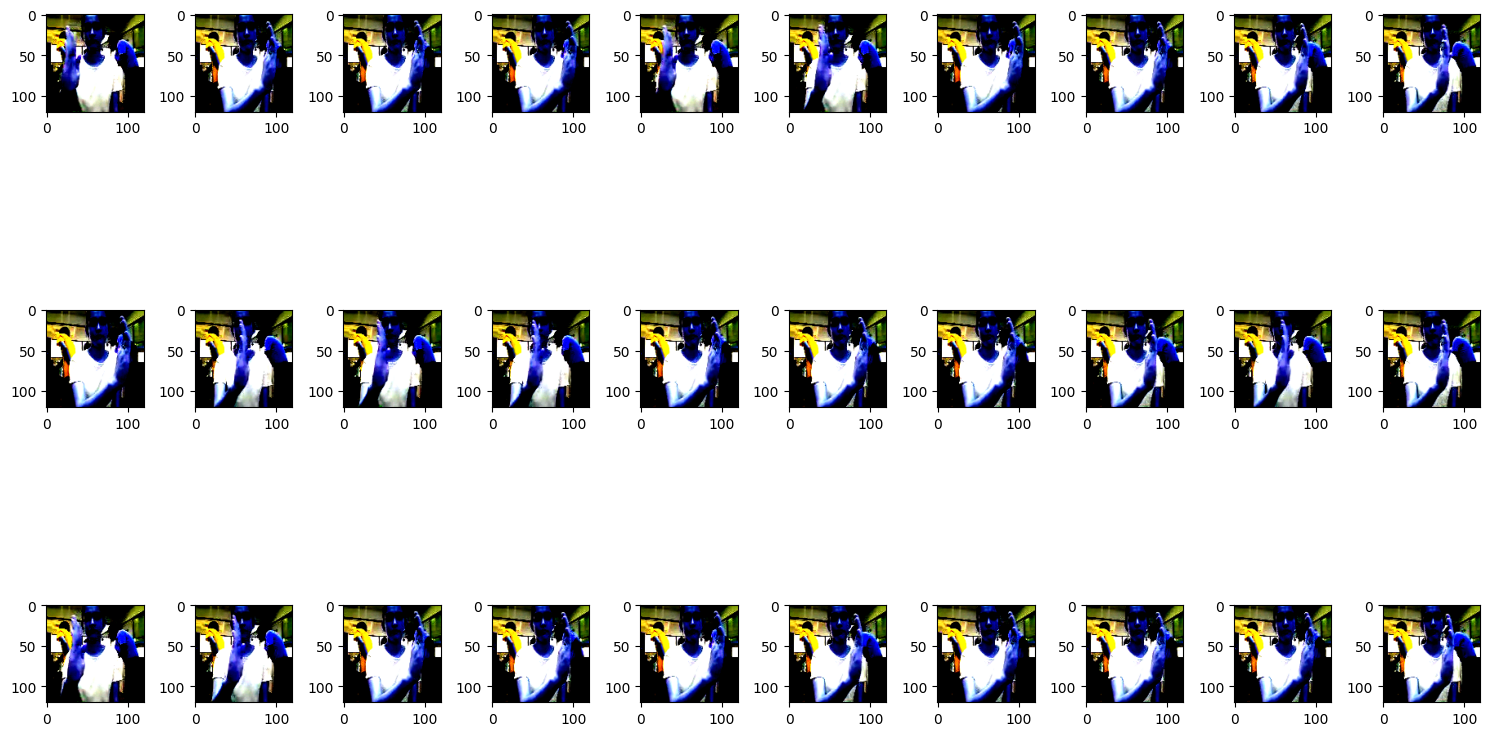

In [49]:
images,_ = next(obj.generator(batch_size=32,source_path=obj.train_path,folder_list=obj.train_doc))
fig,axes = plt.subplots(3,10,figsize=(15,10))
# Flatten the axes array to make it easier to iterate
axes = axes.flatten()
# Assuming img1 contains your images
for ax,img in zip(axes,images[0]): # Display the image on the current subplot
    ax.imshow(img)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### 4. ABLATION EXPERIMENT

##### CONV3D ARCHITECTURE

In [11]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=1,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  1


In [12]:
### Creating the model
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [13]:
## Creating a function  to save the model at the end of each epoch

def save_model(num):
    model_name = f'Exp-{num}_model_init' + '_' + curr_dt_time.strftime(format="%d%m%Y__%H%M%S") + '/'
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.weights.h5'

    ## Callbacks
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto')

    LR = ReduceLROnPlateau(
        monitor = "val_loss",
        factor=0.2, #new_lr = lr * factor
        patience = 2,
        verbose=1,
        mode= 'auto'
    )


    callbacks_list = [checkpoint, LR]
    return filepath,checkpoint,LR,callbacks_list

## Calling the function
filepath,checkpoint,LR,callbacks_list =save_model(0)

In [14]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 60, 60, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 7, 30, 30, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 7, 30, 30, 64)     55360     
                                                        

In [16]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )


Epoch 1: saving model to Exp-0_model_init_29042024__010018/model-00001-1.59646-0.24887-1.51422-0.35000.weights.h5
21/21 - 637s - loss: 1.5965 - categorical_accuracy: 0.2489 - val_loss: 1.5142 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04 - 637s/epoch - 30s/step


In [18]:
## Building a function to visualise the train accuracy, validation accuracy and loss
def graph(history,epochs=num_epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    ##Plotting the training and validation accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    ##Plotting the training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### 5. MODEL BUILDING

#### 5.1 CONV3D ARCHITECTURE

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
### First Experiment

model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(1)


In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 15, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_10 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_10 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_11 (Conv3D)          (None, 7, 30, 30, 64)     55360     
                                                      

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-1_model_init_27042024__002603/model-00001-1.63583-0.32278-1.42183-0.40000.weights.h5
21/21 - 168s - loss: 1.6358 - categorical_accuracy: 0.3228 - val_loss: 1.4218 - val_categorical_accuracy: 0.4000 - lr: 2.0000e-04 - 168s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-1_model_init_27042024__002603/model-00002-1.18902-0.58069-1.26753-0.52000.weights.h5
21/21 - 151s - loss: 1.1890 - categorical_accuracy: 0.5807 - val_loss: 1.2675 - val_categorical_accuracy: 0.5200 - lr: 2.0000e-04 - 151s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-1_model_init_27042024__002603/model-00003-0.80726-0.71041-1.06486-0.65000.weights.h5
21/21 - 142s - loss: 0.8073 - categorical_accuracy: 0.7104 - val_loss: 1.0649 - val_categorical_accuracy: 0.6500 - lr: 2.0000e-04 - 142s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-1_model_init_27042024__002603/model-00004-0.51187-0.83710-1.06011-0.62000.weights.h5
21/21 - 133s - loss: 0.5119 - categor

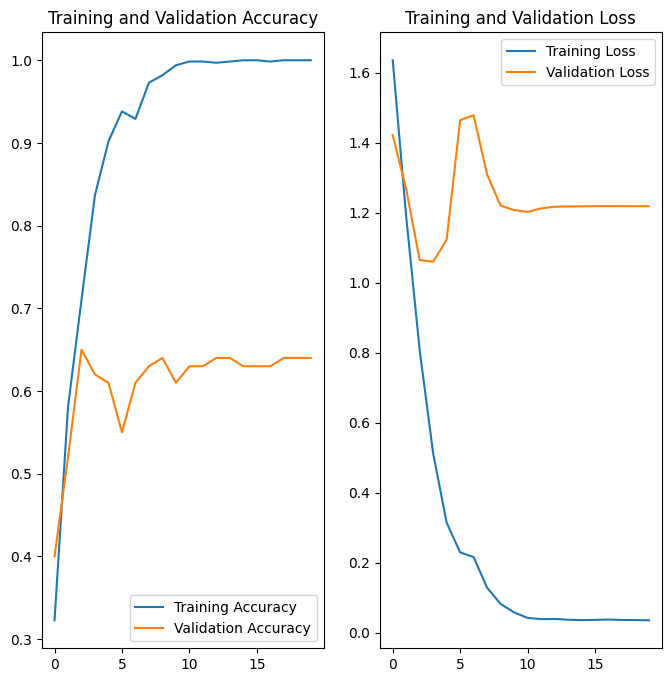

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result = pd.DataFrame(columns=['Model','Epochs','Batch Size','Train_acc','Val_acc','Val_Loss',"Params"])
result.loc[len(result)] = ["Exp-1",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],5600901]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.0,0.64,1.218775,5600901


###### Inference
Clearly our experiment -1 is overfitting since the Training accuracy at the end of 20 epochs is 100% and the validation accuracy is only 64%.

### 5.2 EXPERIMENT-2
##### ADDING DROPOUTS TO THE CONVOLUTION LAYER TO REDUCE OVERFITTING

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(2)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_33 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_34 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_34 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                     

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-2_model_init_27042024__013449/model-00001-2.63884-0.20664-1.60175-0.33000.weights.h5
21/21 - 165s - loss: 2.6388 - categorical_accuracy: 0.2066 - val_loss: 1.6018 - val_categorical_accuracy: 0.3300 - lr: 2.0000e-04 - 165s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-2_model_init_27042024__013449/model-00002-1.59232-0.24736-1.60118-0.25000.weights.h5
21/21 - 150s - loss: 1.5923 - categorical_accuracy: 0.2474 - val_loss: 1.6012 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04 - 150s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-2_model_init_27042024__013449/model-00003-1.57055-0.31523-1.57720-0.35000.weights.h5
21/21 - 142s - loss: 1.5706 - categorical_accuracy: 0.3152 - val_loss: 1.5772 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04 - 142s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-2_model_init_27042024__013449/model-00004-1.50806-0.33635-1.51999-0.33000.weights.h5
21/21 - 134s - loss: 1.5081 - categor

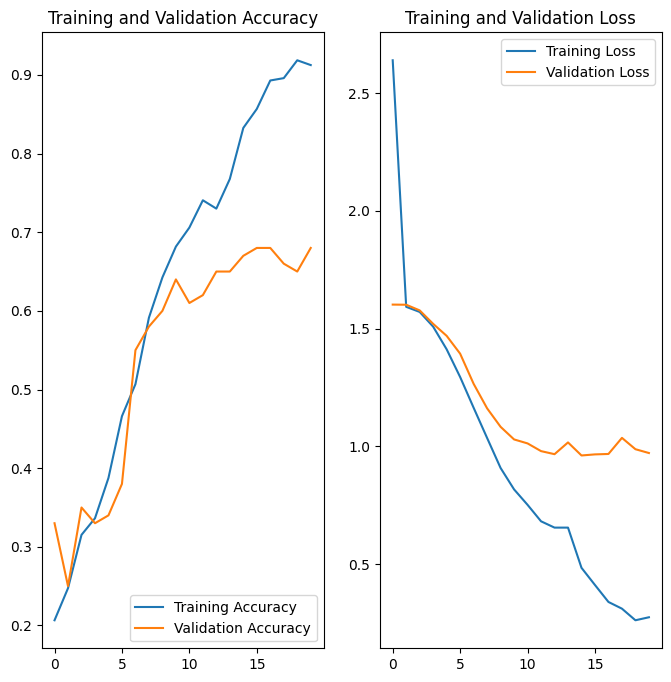

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-2",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],5600901]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901


###### Inference
It seems the model is still overfitting after adding the Dropout layers, however at the end of the final epochs the validation accuracy was beginning to pick up. Lets us add Batch Normalization on the next experiment and test it out.

### 5.3 EXPERIMENT-3
##### ADDING BATCH NORMALIZATION TO THE CONVOLUTION LAYERS TO REDUCE OVERFITTING

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(3)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_37 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                     

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-3_model_init_27042024__022450/model-00001-1.61769-0.44796-1.47120-0.44000.weights.h5
21/21 - 167s - loss: 1.6177 - categorical_accuracy: 0.4480 - val_loss: 1.4712 - val_categorical_accuracy: 0.4400 - lr: 2.0000e-04 - 167s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-3_model_init_27042024__022450/model-00002-0.47439-0.83409-2.09708-0.29000.weights.h5
21/21 - 153s - loss: 0.4744 - categorical_accuracy: 0.8341 - val_loss: 2.0971 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04 - 153s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-3_model_init_27042024__022450/model-00003-0.19376-0.93967-2.96556-0.37000.weights.h5
21/21 - 139s - loss: 0.1938 - categorical_accuracy: 0.9397 - val_loss: 2.9656 - val_categorical_accuracy: 0.3700 - lr: 2.0000e-04 - 139s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-3_model_init_27042024__022450/model-00004-0.09394-0.97587-3.37747-0.39000.weights.h5

Epoch 4: ReduceLROnPlateau reducing 

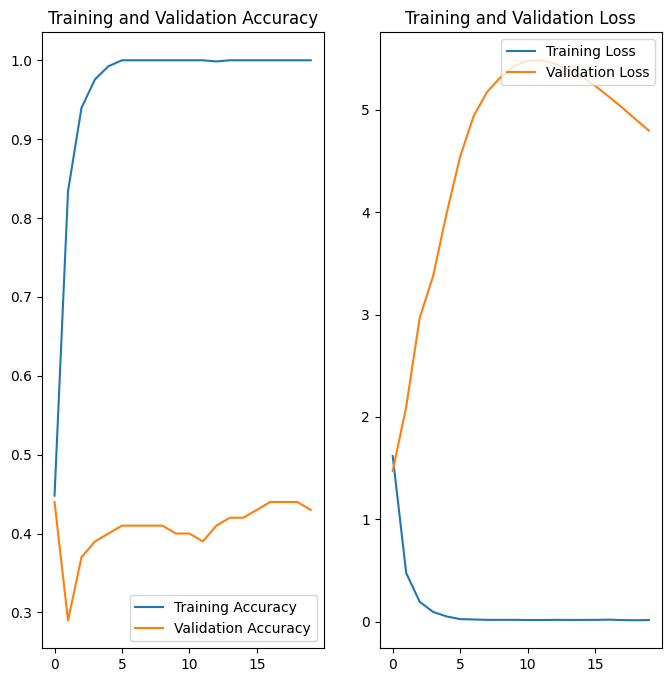

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-3",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],5601349]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349


###### Inference
As per the observation adding BatchNormalization to each of the Convolution layer has got the model to overfit even more. Let's tweak the next model a little bit and see what's the result.

### 5.4 EXPERIMENT-4
##### TWEAKING THE MODEL A LITTLE BIT WITH REGARDS TO BATCH NORMALIZATION AND DROPOUT BOTH

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(4)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_40 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                     

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-4_model_init_27042024__031502/model-00001-2.08394-0.29261-1.55240-0.34000.weights.h5
21/21 - 166s - loss: 2.0839 - categorical_accuracy: 0.2926 - val_loss: 1.5524 - val_categorical_accuracy: 0.3400 - lr: 2.0000e-04 - 166s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-4_model_init_27042024__031502/model-00002-1.17377-0.54299-1.44752-0.44000.weights.h5
21/21 - 150s - loss: 1.1738 - categorical_accuracy: 0.5430 - val_loss: 1.4475 - val_categorical_accuracy: 0.4400 - lr: 2.0000e-04 - 150s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-4_model_init_27042024__031502/model-00003-0.89091-0.66968-1.39006-0.48000.weights.h5
21/21 - 141s - loss: 0.8909 - categorical_accuracy: 0.6697 - val_loss: 1.3901 - val_categorical_accuracy: 0.4800 - lr: 2.0000e-04 - 141s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-4_model_init_27042024__031502/model-00004-0.62416-0.77376-1.43834-0.41000.weights.h5
21/21 - 133s - loss: 0.6242 - categor

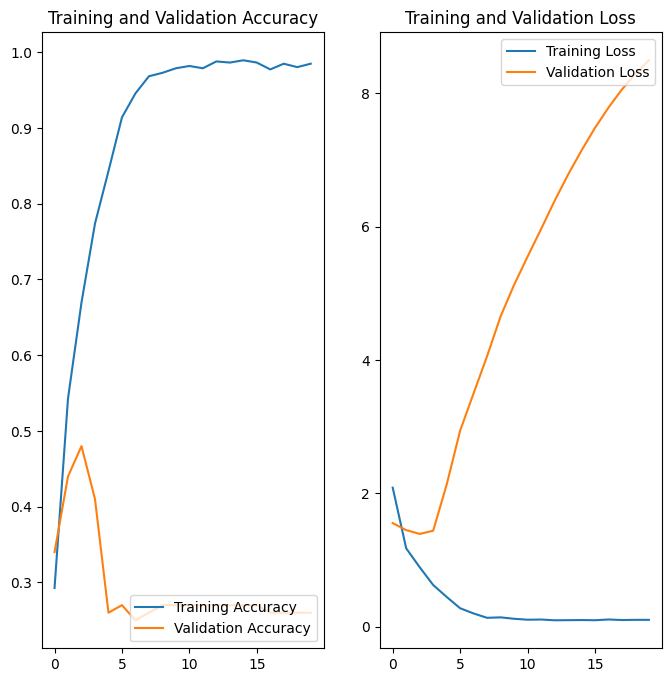

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-4",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],5601157]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157


###### Inference
Clearly the model is is the worst we have created until now. Let's remove the batch normalization and add a convolution layer also on top of it now.

### 5.5 EXPERIMENT-5
##### REMOVING THE BATCH NORMALIZATION AND ADDING UP A CONVOLUTIONAL LAYER

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(5)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_42 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_43 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_43 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                     

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-5_model_init_27042024__040610/model-00001-1.71827-0.20664-1.59997-0.22000.weights.h5
21/21 - 167s - loss: 1.7183 - categorical_accuracy: 0.2066 - val_loss: 1.6000 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04 - 167s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-5_model_init_27042024__040610/model-00002-1.57941-0.26395-1.57904-0.36000.weights.h5
21/21 - 154s - loss: 1.5794 - categorical_accuracy: 0.2640 - val_loss: 1.5790 - val_categorical_accuracy: 0.3600 - lr: 2.0000e-04 - 154s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-5_model_init_27042024__040610/model-00003-1.50277-0.33333-1.51292-0.31000.weights.h5
21/21 - 141s - loss: 1.5028 - categorical_accuracy: 0.3333 - val_loss: 1.5129 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04 - 141s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-5_model_init_27042024__040610/model-00004-1.44817-0.37255-1.48474-0.36000.weights.h5
21/21 - 135s - loss: 1.4482 - categor

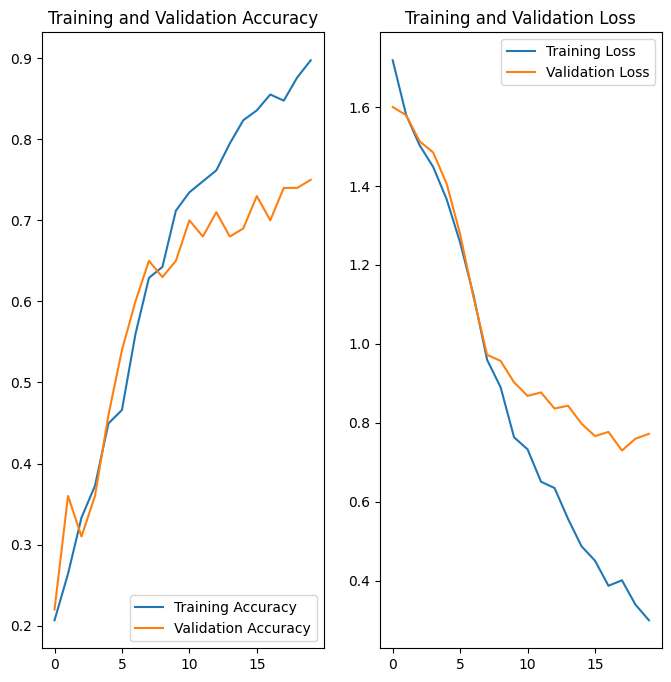

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-5",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],583365]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365


###### Inference
- This is by far the best model we have made, however this one is also slightly overfitting.
- One another major thing we can notice is the parameters have reduced significantly down the line in our Params column.

### 5.6 EXPERIMENT-6
##### ADDING UP ONE MORE CONVOLUTION LAYER AND ALSO INCREASING THE LAST LAYERS DROPOUT VALUE TO 0.5

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(6)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_51 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_51 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_52 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_52 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                     

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-6_model_init_27042024__050033/model-00001-1.63959-0.22172-1.59631-0.27000.weights.h5
21/21 - 167s - loss: 1.6396 - categorical_accuracy: 0.2217 - val_loss: 1.5963 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04 - 167s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-6_model_init_27042024__050033/model-00002-1.58558-0.23982-1.57766-0.30000.weights.h5
21/21 - 152s - loss: 1.5856 - categorical_accuracy: 0.2398 - val_loss: 1.5777 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04 - 152s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-6_model_init_27042024__050033/model-00003-1.55897-0.28507-1.54388-0.31000.weights.h5
21/21 - 140s - loss: 1.5590 - categorical_accuracy: 0.2851 - val_loss: 1.5439 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04 - 140s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-6_model_init_27042024__050033/model-00004-1.50811-0.34842-1.50510-0.38000.weights.h5
21/21 - 135s - loss: 1.5081 - categor

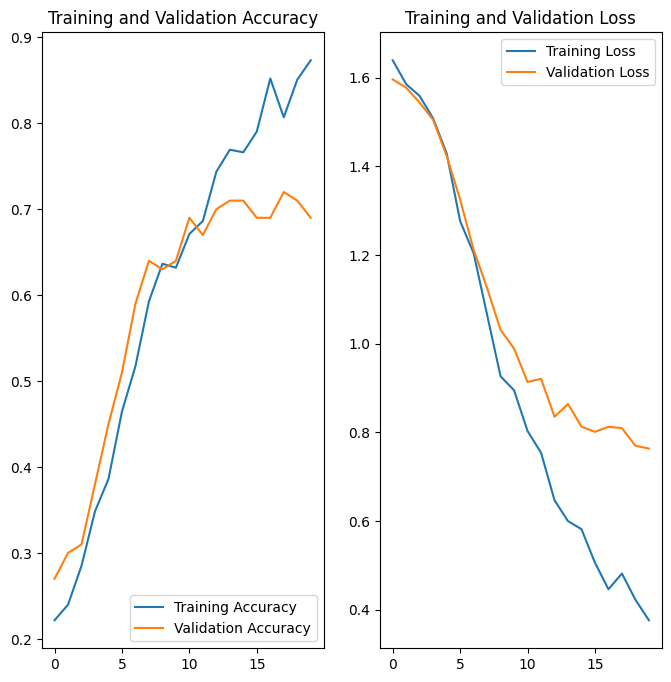

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-6",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],1206085]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085


###### Inference
Exp-5 still seems to be better than the current Exp i.e Exp-6. This model seems to perform well however it is also overfitting.

### 5.7 EXPERIMENT-7
##### TWEAKING THE MODEL BY ADDING ANOTHER CONV3D LAYER FOR 32 FEATURES

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(7)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_90 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_79 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_67 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_91 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 conv3d_92 (Conv3D)          (None, 15, 60, 60, 32)    27680     
                                                                 
 max_pooling3d_80 (MaxPooli  (None, 7, 30, 30, 32)   

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-7_model_init_27042024__060347/model-00001-1.66162-0.20060-1.59808-0.33000.weights.h5
21/21 - 169s - loss: 1.6616 - categorical_accuracy: 0.2006 - val_loss: 1.5981 - val_categorical_accuracy: 0.3300 - lr: 2.0000e-04 - 169s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-7_model_init_27042024__060347/model-00002-1.57153-0.27300-1.57308-0.30000.weights.h5
21/21 - 151s - loss: 1.5715 - categorical_accuracy: 0.2730 - val_loss: 1.5731 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04 - 151s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-7_model_init_27042024__060347/model-00003-1.52952-0.30468-1.51472-0.38000.weights.h5
21/21 - 141s - loss: 1.5295 - categorical_accuracy: 0.3047 - val_loss: 1.5147 - val_categorical_accuracy: 0.3800 - lr: 2.0000e-04 - 141s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-7_model_init_27042024__060347/model-00004-1.46837-0.34540-1.47291-0.44000.weights.h5
21/21 - 133s - loss: 1.4684 - categor

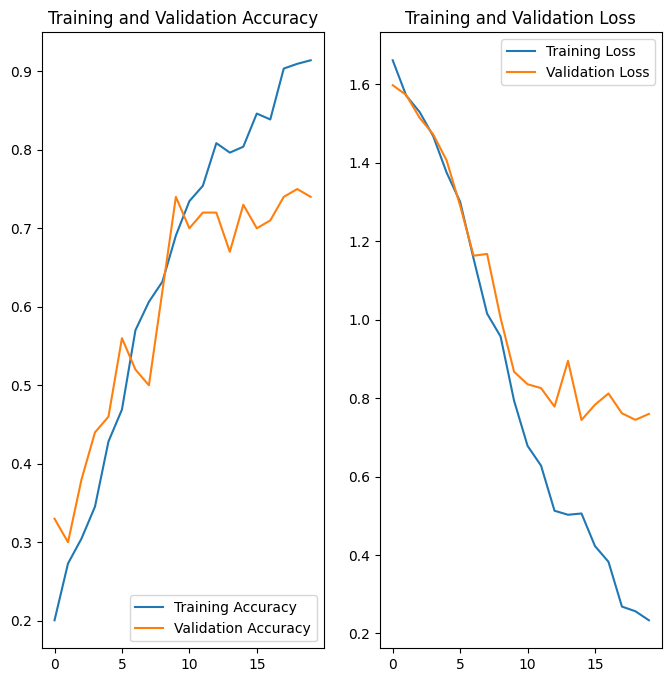

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-7",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],611045]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045


###### Inference
- The above experiment is also overfitting however, we are able to get progressively good results.

### 5.8 EXPERIMENT-8
##### TWEAKING THE MODEL BY ADDING A DROPOUT LAYER AFTER THE DENSE LAYER

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(8)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_95 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_83 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_71 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_96 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 conv3d_97 (Conv3D)          (None, 15, 60, 60, 32)    27680     
                                                                 
 max_pooling3d_84 (MaxPooli  (None, 7, 30, 30, 32)   

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-8_model_init_27042024__070548/model-00001-1.66179-0.21569-1.60228-0.27000.weights.h5
21/21 - 167s - loss: 1.6618 - categorical_accuracy: 0.2157 - val_loss: 1.6023 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04 - 167s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-8_model_init_27042024__070548/model-00002-1.58053-0.26244-1.58289-0.35000.weights.h5
21/21 - 151s - loss: 1.5805 - categorical_accuracy: 0.2624 - val_loss: 1.5829 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04 - 151s/epoch - 7s/step
Epoch 3/20

Epoch 3: saving model to Exp-8_model_init_27042024__070548/model-00003-1.50654-0.35143-1.51817-0.31000.weights.h5
21/21 - 141s - loss: 1.5065 - categorical_accuracy: 0.3514 - val_loss: 1.5182 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04 - 141s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-8_model_init_27042024__070548/model-00004-1.44222-0.37858-1.46182-0.32000.weights.h5
21/21 - 134s - loss: 1.4422 - categor

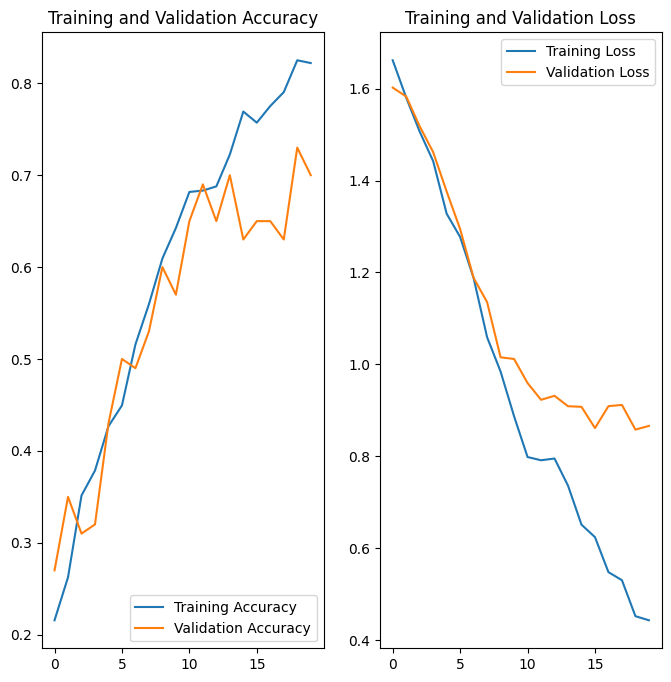

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-8",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],611045]
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045


###### Inference
- This model is also performing like the previous ones since there is still overfitting involved. Let's take the Exp-5 model and then do augmentation on the top of it to check if anything changes.

### 5.9 EXPERIMENT-9
##### AUGMENTATION

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(9)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_21 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                      

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-9_model_init_27042024__132037/model-00001-1.72967-0.21116-1.60041-0.24000.weights.h5
21/21 - 177s - loss: 1.7297 - categorical_accuracy: 0.2112 - val_loss: 1.6004 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04 - 177s/epoch - 8s/step
Epoch 2/20

Epoch 2: saving model to Exp-9_model_init_27042024__132037/model-00002-1.58373-0.26546-1.58404-0.36000.weights.h5
21/21 - 161s - loss: 1.5837 - categorical_accuracy: 0.2655 - val_loss: 1.5840 - val_categorical_accuracy: 0.3600 - lr: 2.0000e-04 - 161s/epoch - 8s/step
Epoch 3/20

Epoch 3: saving model to Exp-9_model_init_27042024__132037/model-00003-1.54319-0.29110-1.55338-0.31000.weights.h5
21/21 - 149s - loss: 1.5432 - categorical_accuracy: 0.2911 - val_loss: 1.5534 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04 - 149s/epoch - 7s/step
Epoch 4/20

Epoch 4: saving model to Exp-9_model_init_27042024__132037/model-00004-1.49909-0.32730-1.51831-0.33000.weights.h5
21/21 - 141s - loss: 1.4991 - categor

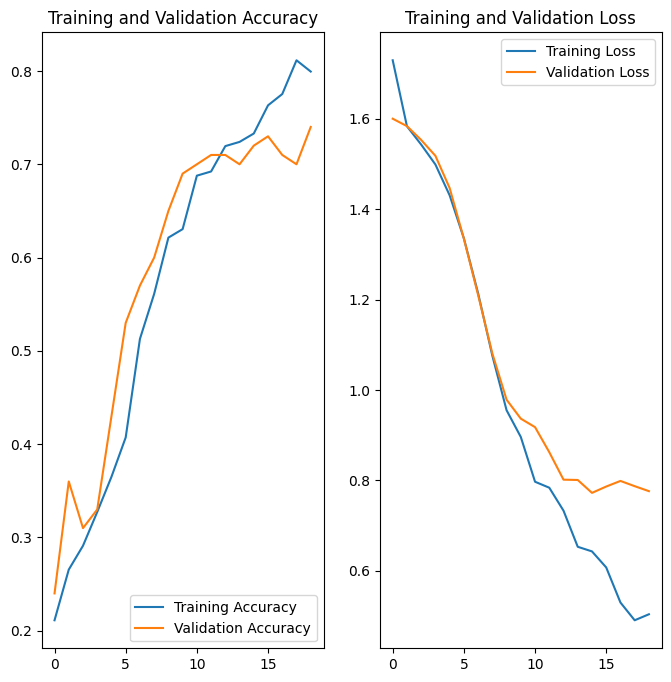

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-8",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],611045]
result

In [ ]:
result

,Model,Epochs,Batch Size,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365


###### Inference
- This is by far the best model we have made. The model is predicting on the unseen data very well.

### 5.10 EXPERIMENT-10
##### AUGMENTATION, WITH BATCH_SIZE=64, EPOCHS=30

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=30,batch_size=64,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  30


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(10)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 15, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 7, 30, 30, 32)     0         
 g3D)                                                            
                                                      

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/30

Epoch 1: saving model to Exp-10_model_init_27042024__151306/model-00001-1.74502-0.19608-1.59470-0.35000.weights.h5
11/11 - 188s - loss: 1.7450 - categorical_accuracy: 0.1961 - val_loss: 1.5947 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04 - 188s/epoch - 17s/step
Epoch 2/30

Epoch 2: saving model to Exp-10_model_init_27042024__151306/model-00002-1.59027-0.24736-1.59734-0.20000.weights.h5
11/11 - 131s - loss: 1.5903 - categorical_accuracy: 0.2474 - val_loss: 1.5973 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04 - 131s/epoch - 12s/step
Epoch 3/30

Epoch 3: saving model to Exp-10_model_init_27042024__151306/model-00003-1.57843-0.23982-1.58370-0.32000.weights.h5
11/11 - 164s - loss: 1.5784 - categorical_accuracy: 0.2398 - val_loss: 1.5837 - val_categorical_accuracy: 0.3200 - lr: 2.0000e-04 - 164s/epoch - 15s/step
Epoch 4/30

Epoch 4: saving model to Exp-10_model_init_27042024__151306/model-00004-1.55941-0.28356-1.56479-0.45000.weights.h5
11/11 - 141s - loss: 1.5594 - 

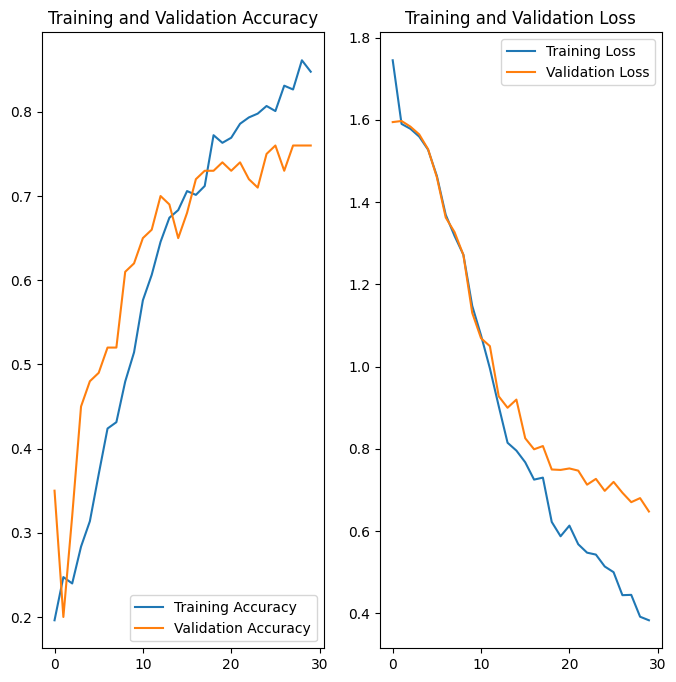

In [ ]:
### Plotting the graph
graph(history,epochs=30)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-10",30,64,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],583365]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- We do have a good Accuracy overall in this case also.

### 5.11 EXPERIMENT-11
##### AUGMENTATION, WITH BATCH_SIZE=100, EPOCHS=20

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=100,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(11)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_19 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_20 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                      

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-11_model_init_27042024__165517/model-00001-1.75753-0.18401-1.61446-0.27000.weights.h5
7/7 - 202s - loss: 1.7575 - categorical_accuracy: 0.1840 - val_loss: 1.6145 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04 - 202s/epoch - 29s/step
Epoch 2/20

Epoch 2: saving model to Exp-11_model_init_27042024__165517/model-00002-1.60697-0.23831-1.59740-0.33000.weights.h5
7/7 - 144s - loss: 1.6070 - categorical_accuracy: 0.2383 - val_loss: 1.5974 - val_categorical_accuracy: 0.3300 - lr: 2.0000e-04 - 144s/epoch - 21s/step
Epoch 3/20

Epoch 3: saving model to Exp-11_model_init_27042024__165517/model-00003-1.59302-0.26395-1.58967-0.41000.weights.h5
7/7 - 149s - loss: 1.5930 - categorical_accuracy: 0.2640 - val_loss: 1.5897 - val_categorical_accuracy: 0.4100 - lr: 2.0000e-04 - 149s/epoch - 21s/step
Epoch 4/20

Epoch 4: saving model to Exp-11_model_init_27042024__165517/model-00004-1.57516-0.29713-1.57913-0.41000.weights.h5
7/7 - 149s - loss: 1.5752 - categori

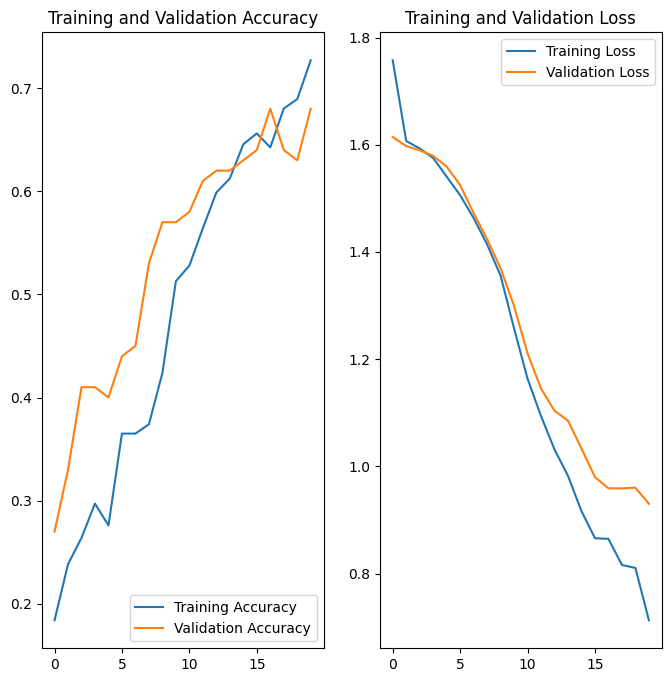

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-11",30,100,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],583365]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- Clearly our mode, is performing very well.

### 5.12 EXPERIMENT-12
##### AUGMENTATION, WITH BATCH_SIZE=100, EPOCHS=40

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=40,batch_size=100,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  40


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=3,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(12)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_23 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_24 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 7, 30, 30, 32)     0         
 ng3D)                                                           
                                                      

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/40

Epoch 1: saving model to Exp-11_model_init_27042024__181101/model-00001-1.80188-0.19306-1.60369-0.22000.weights.h5
7/7 - 176s - loss: 1.8019 - categorical_accuracy: 0.1931 - val_loss: 1.6037 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04 - 176s/epoch - 25s/step
Epoch 2/40

Epoch 2: saving model to Exp-11_model_init_27042024__181101/model-00002-1.62793-0.18401-1.60824-0.20000.weights.h5
7/7 - 147s - loss: 1.6279 - categorical_accuracy: 0.1840 - val_loss: 1.6082 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04 - 147s/epoch - 21s/step
Epoch 3/40

Epoch 3: saving model to Exp-11_model_init_27042024__181101/model-00003-1.58734-0.24736-1.59494-0.30000.weights.h5
7/7 - 148s - loss: 1.5873 - categorical_accuracy: 0.2474 - val_loss: 1.5949 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04 - 148s/epoch - 21s/step
Epoch 4/40

Epoch 4: saving model to Exp-11_model_init_27042024__181101/model-00004-1.57678-0.26546-1.58532-0.32000.weights.h5
7/7 - 148s - loss: 1.5768 - categori

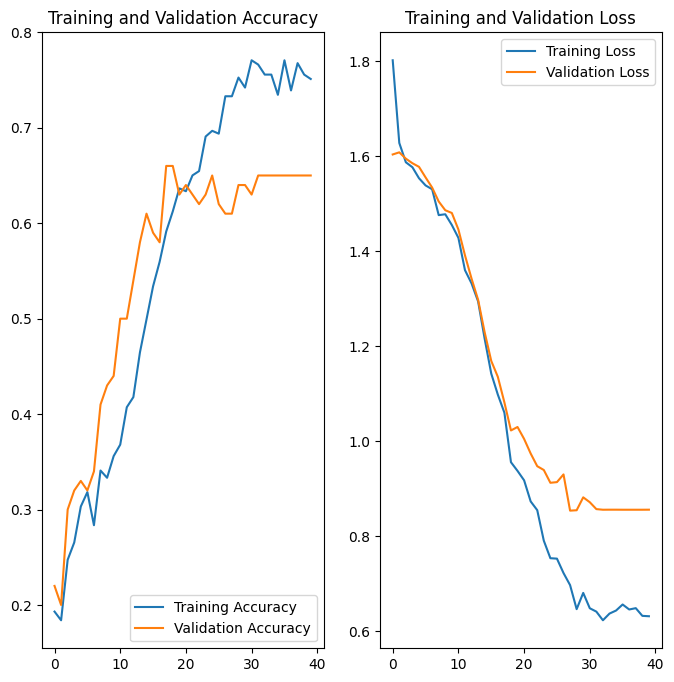

In [ ]:
### Plotting the graph
graph(history,epochs=40)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-12",40,100,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],583365]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365



###### Inference
- As per the observation we can say the model is slightly overfitting, also as the epochs are increasing the accuracy also seems to not improve.

### 5.13 EXPERIMENT-13
##### CNN+ RNN ARCHITECTURE
##### TRANSFER LEARNING + GRU, WITH BATCH_SIZE=32, EPOCHS=20

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
# Model Building
gru_units = 128
## Loading the mobilenetv2 model
base_model  = MobileNetV2(weights = 'imagenet',include_top=False,input_shape=(obj.image_width,obj.image_height,obj.num_channels))

model = Sequential()
model.add(TimeDistributed(base_model,input_shape = input_shape))

## Setting MobileNetV2 as non-trainable
for layer in model.layers:
  layer.trainable=False

model.add(TimeDistributed(Flatten()))


# Add a GRU layer
model.add(GRU(gru_units, return_sequences=False))


model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(13)

In [ ]:
## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 30, 4, 4, 1280)    2257984   
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 20480)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)               7914240   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 10180805 (38.84 MB)
Trainable params: 79

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-13_model_init_28042024__093027/model-00001-1.41213-0.42383-1.22961-0.58000.weights.h5
21/21 - 217s - loss: 1.4121 - categorical_accuracy: 0.4238 - val_loss: 1.2296 - val_categorical_accuracy: 0.5800 - lr: 2.0000e-04 - 217s/epoch - 10s/step
Epoch 2/20

Epoch 2: saving model to Exp-13_model_init_28042024__093027/model-00002-0.91176-0.72398-0.95587-0.67000.weights.h5
21/21 - 189s - loss: 0.9118 - categorical_accuracy: 0.7240 - val_loss: 0.9559 - val_categorical_accuracy: 0.6700 - lr: 2.0000e-04 - 189s/epoch - 9s/step
Epoch 3/20

Epoch 3: saving model to Exp-13_model_init_28042024__093027/model-00003-0.62747-0.86425-0.86701-0.69000.weights.h5
21/21 - 175s - loss: 0.6275 - categorical_accuracy: 0.8643 - val_loss: 0.8670 - val_categorical_accuracy: 0.6900 - lr: 2.0000e-04 - 175s/epoch - 8s/step
Epoch 4/20

Epoch 4: saving model to Exp-13_model_init_28042024__093027/model-00004-0.42825-0.93816-0.82378-0.72000.weights.h5
21/21 - 168s - loss: 0.4282 - ca

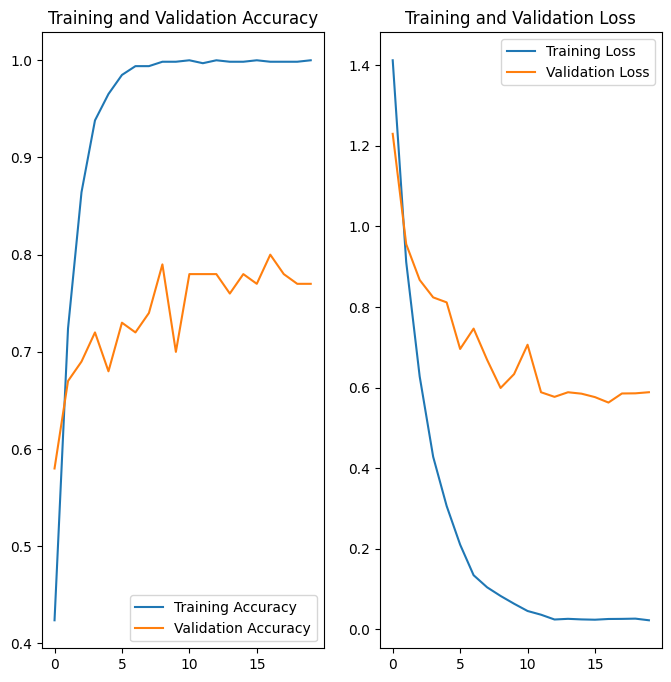

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-13",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],10180805]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- Our model is overfitting however we will try to add dropout layers in the next experiment and try to minimize the loss.

### 5.14 EXPERIMENT-14
##### ADDING DROPOUT LAYER TO EXP-13, WITH BATCH_SIZE=32, EPOCHS=20

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
# Model Building
gru_units = 128
## Loading the mobilenetv2 model
base_model  = MobileNetV2(weights = 'imagenet',include_top=False,input_shape=(obj.image_width,obj.image_height,obj.num_channels))

model = Sequential()
model.add(TimeDistributed(base_model,input_shape = input_shape))

## Setting MobileNetV2 as non-trainable
for layer in model.layers:
  layer.trainable=False

model.add(TimeDistributed(Flatten()))


# Add a GRU layer
model.add(GRU(gru_units, return_sequences=False))
model.add(Dropout(0.25))


model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(14)

## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 30, 4, 4, 1280)    2257984   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 30, 20480)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)               7914240   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

In [ ]:
### Training the model

history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-14_model_init_28042024__103203/model-00001-1.63615-0.27149-1.46198-0.42000.weights.h5
21/21 - 211s - loss: 1.6361 - categorical_accuracy: 0.2715 - val_loss: 1.4620 - val_categorical_accuracy: 0.4200 - lr: 2.0000e-04 - 211s/epoch - 10s/step
Epoch 2/20

Epoch 2: saving model to Exp-14_model_init_28042024__103203/model-00002-1.39317-0.42232-1.36341-0.54000.weights.h5
21/21 - 190s - loss: 1.3932 - categorical_accuracy: 0.4223 - val_loss: 1.3634 - val_categorical_accuracy: 0.5400 - lr: 2.0000e-04 - 190s/epoch - 9s/step
Epoch 3/20

Epoch 3: saving model to Exp-14_model_init_28042024__103203/model-00003-1.30854-0.47964-1.25942-0.54000.weights.h5
21/21 - 177s - loss: 1.3085 - categorical_accuracy: 0.4796 - val_loss: 1.2594 - val_categorical_accuracy: 0.5400 - lr: 2.0000e-04 - 177s/epoch - 8s/step
Epoch 4/20

Epoch 4: saving model to Exp-14_model_init_28042024__103203/model-00004-1.18724-0.54449-1.12184-0.62000.weights.h5
21/21 - 170s - loss: 1.1872 - ca

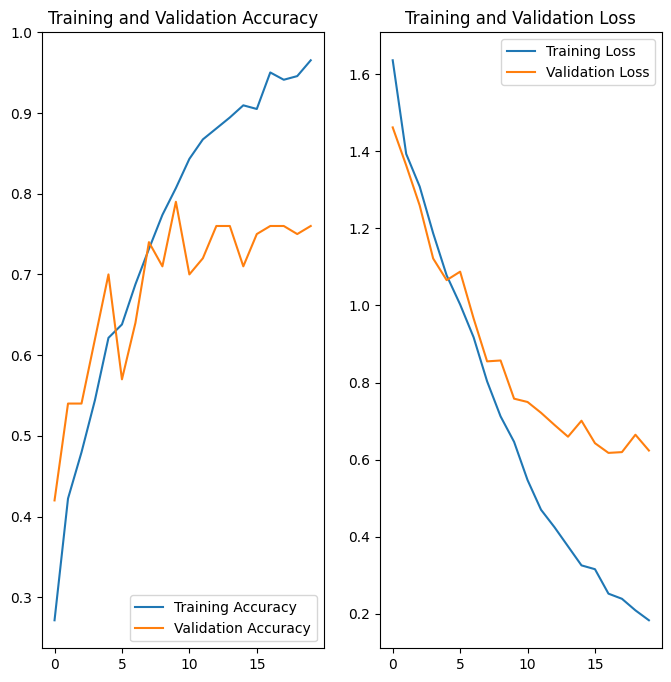

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [1]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-14",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],10180805]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- The model is still overfitting however we will try to do transfer learning on a new model and also reduce the GRU units and try.

### 5.15 EXPERIMENT-15
##### TRYING OUT TRANSFER LEARNING USING XCEPTION MODEL AND CHANGING GRU UNITS TO 64

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
# Model Building
gru_units = 64
## Loading the mobilenetv2 model
base_model  = Xception(weights = 'imagenet',include_top=False,input_shape=(obj.image_width,obj.image_height,obj.num_channels))

model = Sequential()
model.add(TimeDistributed(base_model,input_shape = input_shape))

## Setting MobileNetV2 as non-trainable
for layer in model.layers:
  layer.trainable=False

model.add(TimeDistributed(Flatten()))


# Add a GRU layer
model.add(GRU(gru_units, return_sequences=False))
model.add(Dropout(0.25))


model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(15)

## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 30, 4, 4, 2048)    20861480  
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 30, 32768)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)                6304128   
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [ ]:
history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-14_model_init_28042024__113300/model-00001-1.70302-0.23228-1.52253-0.33000.weights.h5
21/21 - 225s - loss: 1.7030 - categorical_accuracy: 0.2323 - val_loss: 1.5225 - val_categorical_accuracy: 0.3300 - lr: 2.0000e-04 - 225s/epoch - 11s/step
Epoch 2/20

Epoch 2: saving model to Exp-14_model_init_28042024__113300/model-00002-1.50151-0.32881-1.33592-0.50000.weights.h5
21/21 - 195s - loss: 1.5015 - categorical_accuracy: 0.3288 - val_loss: 1.3359 - val_categorical_accuracy: 0.5000 - lr: 2.0000e-04 - 195s/epoch - 9s/step
Epoch 3/20

Epoch 3: saving model to Exp-14_model_init_28042024__113300/model-00003-1.39601-0.40271-1.30505-0.56000.weights.h5
21/21 - 183s - loss: 1.3960 - categorical_accuracy: 0.4027 - val_loss: 1.3050 - val_categorical_accuracy: 0.5600 - lr: 2.0000e-04 - 183s/epoch - 9s/step
Epoch 4/20

Epoch 4: saving model to Exp-14_model_init_28042024__113300/model-00004-1.28469-0.45701-1.23820-0.49000.weights.h5
21/21 - 175s - loss: 1.2847 - ca

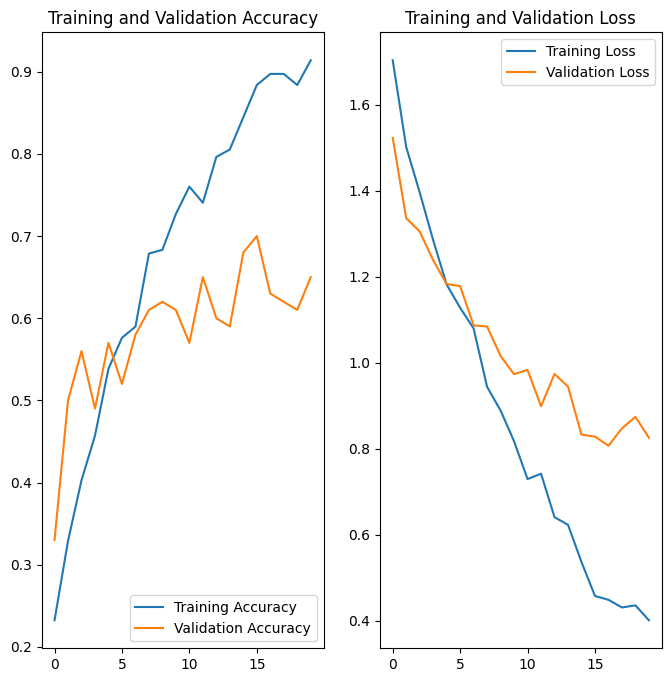

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [2]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-15",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],27170093]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- The model is still overfitting, we will try the next experiment with MobileNet

### 5.16 EXPERIMENT-16
##### TRYING OUT TRANSFER LEARNING USING MOBILENET MODEL AND CHANGING GRU UNITS TO 64

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=20,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  20


In [ ]:
# Model Building
gru_units = 64
## Loading the mobilenetv2 model
base_model  = MobileNet(weights = 'imagenet',include_top=False,input_shape=(obj.image_width,obj.image_height,obj.num_channels))

model = Sequential()
model.add(TimeDistributed(base_model,input_shape = input_shape))

## Setting MobileNetV2 as non-trainable
for layer in model.layers:
  layer.trainable=False

model.add(TimeDistributed(Flatten()))


# Add a GRU layer
model.add(GRU(gru_units, return_sequences=False))
model.add(Dropout(0.50))


model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='softmax'))

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(16)

## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, 30, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 30, 9216)          0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 64)                1782144   
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 5)                

In [ ]:
history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
     )

Epoch 1/20

Epoch 1: saving model to Exp-16_model_init_28042024__123556/model-00001-1.71592-0.26244-1.41158-0.45000.weights.h5
21/21 - 208s - loss: 1.7159 - categorical_accuracy: 0.2624 - val_loss: 1.4116 - val_categorical_accuracy: 0.4500 - lr: 2.0000e-04 - 208s/epoch - 10s/step
Epoch 2/20

Epoch 2: saving model to Exp-16_model_init_28042024__123556/model-00002-1.42871-0.40121-1.21465-0.56000.weights.h5
21/21 - 190s - loss: 1.4287 - categorical_accuracy: 0.4012 - val_loss: 1.2147 - val_categorical_accuracy: 0.5600 - lr: 2.0000e-04 - 190s/epoch - 9s/step
Epoch 3/20

Epoch 3: saving model to Exp-16_model_init_28042024__123556/model-00003-1.21161-0.52790-1.11901-0.61000.weights.h5
21/21 - 175s - loss: 1.2116 - categorical_accuracy: 0.5279 - val_loss: 1.1190 - val_categorical_accuracy: 0.6100 - lr: 2.0000e-04 - 175s/epoch - 8s/step
Epoch 4/20

Epoch 4: saving model to Exp-16_model_init_28042024__123556/model-00004-1.04959-0.61991-0.97259-0.65000.weights.h5
21/21 - 167s - loss: 1.0496 - ca

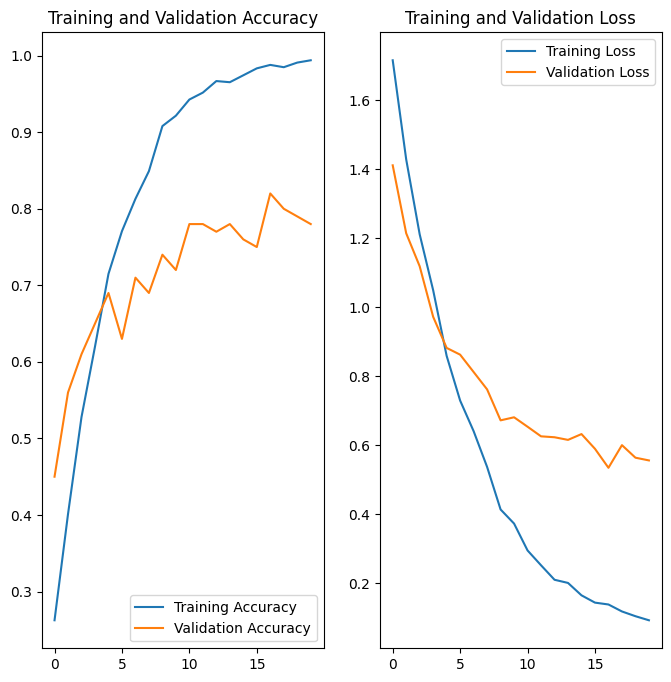

In [ ]:
### Plotting the graph
graph(history,epochs=20)

In [ ]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-16",20,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],5015493]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- The current model is also overfitting, however this is the first time we were able to achieve 80% accuracy throughout the training. In out next experiment we will remove the frozen weights of tranfer learning.

### 5.17 EXPERIMENT-17
##### WE WILL ALSO TRY OUT AN EXPERIMENT WHERE IN WE HAVE CHANGED THE FILTER SIZE TO 2 on TOP OF THE MODEL MADE ON EXP-9

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=30,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  30


In [ ]:
#Model Building
model =Sequential()
model.add(Conv3D(16,kernel_size=2,activation='relu',padding='same',input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(32, kernel_size=2,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=2,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=2,activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(17)

## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 16   400       
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 15, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 7, 30, 30, 32)     0         
 g3D)                                                            
                                                      

In [ ]:
history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/30

Epoch 1: saving model to Exp-17_model_init_28042024__182926/model-00001-1.72192-0.20814-1.60038-0.22000.weights.h5
21/21 - 206s - loss: 1.7219 - categorical_accuracy: 0.2081 - val_loss: 1.6004 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04 - 206s/epoch - 10s/step
Epoch 2/30

Epoch 2: saving model to Exp-17_model_init_28042024__182926/model-00002-1.57632-0.28205-1.58250-0.35000.weights.h5
21/21 - 185s - loss: 1.5763 - categorical_accuracy: 0.2821 - val_loss: 1.5825 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04 - 185s/epoch - 9s/step
Epoch 3/30

Epoch 3: saving model to Exp-17_model_init_28042024__182926/model-00003-1.54383-0.28205-1.56560-0.39000.weights.h5
21/21 - 175s - loss: 1.5438 - categorical_accuracy: 0.2821 - val_loss: 1.5656 - val_categorical_accuracy: 0.3900 - lr: 2.0000e-04 - 175s/epoch - 8s/step
Epoch 4/30

Epoch 4: saving model to Exp-17_model_init_28042024__182926/model-00004-1.48835-0.34540-1.53424-0.37000.weights.h5
21/21 - 165s - loss: 1.4884 - ca

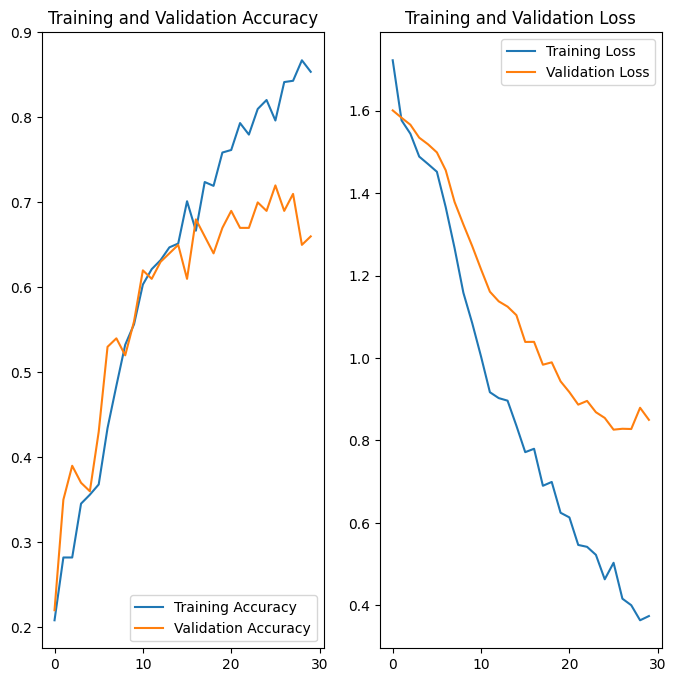

In [ ]:
### Plotting the graph
graph(history,epochs=30)

In [20]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-17",30,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],455989]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- The model was built inorder to test a model by changing the kernel size to 2 instead of .
- Model is overfitting. We will make our final model using the CNN+RNN Architecture itself.

### 5.18 EXPERIMENT-18 (FINAL MODEL)
##### REMOVING THE FREEZING=FALSE PARAMETER AND TRAINING THE WEIGHTS OF THE MOBILENET MODEL

In [ ]:
## Calling the function prep
train_generator,val_generator,curr_dt_time,num_train_sequences,num_val_sequences,num_epochs,steps_per_epoch,validation_steps,input_shape = prep(epochs=25,batch_size=32,data_augmentation=True)

# training sequences = 663
# validation sequences = 100
# Number of epochs =  25


In [ ]:
# Model Building
gru_units = 64
## Loading the mobilenetv2 model
base_model  = MobileNet(weights = 'imagenet',include_top=False,input_shape=(obj.image_width,obj.image_height,obj.num_channels))

model = Sequential()
model.add(TimeDistributed(base_model,input_shape = input_shape))

model.add(TimeDistributed(Flatten()))


# Add a GRU layer
model.add(GRU(gru_units, return_sequences=False))
model.add(Dropout(0.50))


model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [ ]:
## Calling save model function
filepath,checkpoint,LR,callbacks_list = save_model(18)

## Compilation of the model
optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 30, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 9216)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 64)                1782144   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
history = model.fit(x = train_generator,
    epochs = num_epochs,
    verbose=2,
    callbacks = callbacks_list,
    validation_data = val_generator,
    class_weight = None,
    initial_epoch=0,
    steps_per_epoch = steps_per_epoch,
    validation_steps=validation_steps
)

Epoch 1/25

Epoch 1: saving model to Exp-18_model_init_28042024__170641/model-00001-1.72559-0.25490-1.51516-0.32000.weights.h5
21/21 - 240s - loss: 1.7256 - categorical_accuracy: 0.2549 - val_loss: 1.5152 - val_categorical_accuracy: 0.3200 - lr: 2.0000e-04 - 240s/epoch - 11s/step
Epoch 2/25

Epoch 2: saving model to Exp-18_model_init_28042024__170641/model-00002-1.25644-0.47210-1.23112-0.51000.weights.h5
21/21 - 200s - loss: 1.2564 - categorical_accuracy: 0.4721 - val_loss: 1.2311 - val_categorical_accuracy: 0.5100 - lr: 2.0000e-04 - 200s/epoch - 10s/step
Epoch 3/25

Epoch 3: saving model to Exp-18_model_init_28042024__170641/model-00003-0.87456-0.68477-1.00578-0.61000.weights.h5
21/21 - 185s - loss: 0.8746 - categorical_accuracy: 0.6848 - val_loss: 1.0058 - val_categorical_accuracy: 0.6100 - lr: 2.0000e-04 - 185s/epoch - 9s/step
Epoch 4/25

Epoch 4: saving model to Exp-18_model_init_28042024__170641/model-00004-0.63798-0.79186-0.76988-0.72000.weights.h5
21/21 - 178s - loss: 0.6380 - c

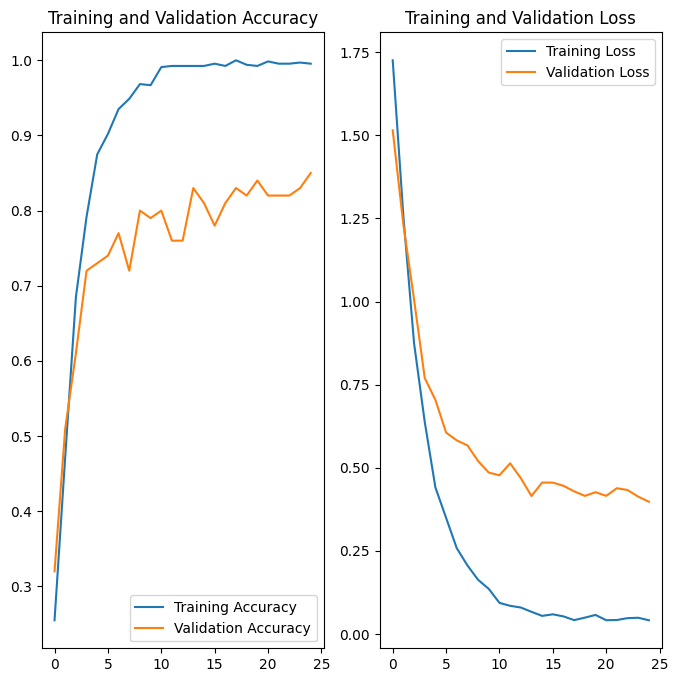

In [ ]:
### Plotting the graph
graph(history,epochs=25)

In [21]:
### Putting up the result inside a dataframe
result.loc[len(result)] = ["Exp-18",25,32,history.history['categorical_accuracy'][-1],history.history['val_categorical_accuracy'][-1],history.history['val_loss'][-1],5015493]
result

,Model,Epochs,Batch Size\t,Train_acc,Val_acc,Val_Loss,Params
0,Exp-1,20,32,1.000000,0.64,1.218775,5600901
1,Exp-2,20,32,0.912519,0.68,0.971824,5600901
2,Exp-3,20,32,1.000000,0.43,4.796840,5601349
3,Exp-4,20,32,0.984917,0.26,8.495330,5601157
4,Exp-5,20,32,0.897436,0.75,0.772125,583365
5,Exp-6,20,32,0.873303,0.69,0.763479,1206085
6,Exp-7,20,32,0.914027,0.74,0.759801,611045
7,Exp-8,20,32,0.822021,0.70,0.866076,611045
8,Exp-9,20,32,0.799400,0.74,0.776400,583365
9,Exp-10,30,64,0.847700,0.76,0.647700,583365


###### Inference
- The model is overfitting slightly. However this is the best model in terms of validation accuracy that we have achieved.